# HW_REGRESSION_Dimas Adi Prasetyo

Assignment: Ridge & Lasso Regression on Boston Housing Dataset

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


## 2. Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
boston = pd.read_csv('/content/drive/MyDrive/Dibimbing Bootcamp Data Science/boston.csv')
boston.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
missing_values = boston.isnull().sum()
missing_values

,0
crim,0
zn,0
indus,0
chas,0
nox,0
rm,0
age,0
dis,0
rad,0
tax,0


In [ ]:
duplicated = boston.duplicated().sum()
duplicated

np.int64(0)

## 3. Pisahkan Fitur dan Target

In [ ]:
feature = boston.drop(columns='medv')
target = boston[['medv']]

## 4. Split Data (Train, Validation, Test)

In [ ]:
# First splitting: pretrain and test
feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_boston_train, feature_boston_validation, target_boston_train, target_boston_validation = train_test_split(feature_boston_pretrain, target_boston_pretrain, test_size=0.20, random_state=42)

feature_boston_train.shape, feature_boston_test.shape

((323, 13), (102, 13))

## 5. Correlation Matrix

In [ ]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


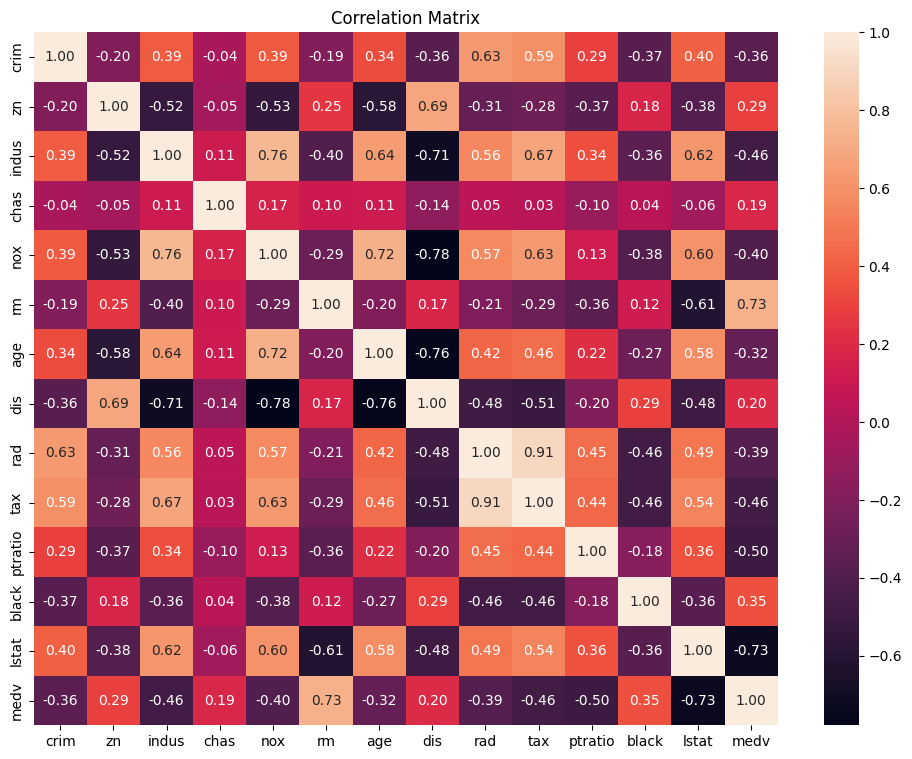

In [ ]:
# heatmap correlation
data_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = data_train.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Pemilihan Fitur Berdasarkan Korelasi

Untuk mengurangi multikolinearitas, fitur dengan koefisien korelasi di atas **0,8** ditinjau.
Misalnya, `RAD` dan `TAX` menunjukkan korelasi yang kuat. Menyertakan keduanya dapat menyebabkan redundansi, jadi saya mempertimbangkan untuk menghilangkan satu untuk meningkatkan stabilitas model.

## 6. Drop Fitur dengan Multikolinearitas Tinggi

In [ ]:
feature_boston_train = feature_boston_train.drop(columns=['rad'])
feature_boston_validation = feature_boston_validation.drop(columns=['rad'])
feature_boston_test = feature_boston_test.drop(columns=['rad'])

Alasan mendrop 'rad':

*  VIF tinggi.
*  Korelasi sangat tinggi dengan tax yang mana berarti informasi serupa/mirip.
*  lebih baik simpan tax karena lebih interpretatif (jumlah pajak properti)
*  Menurunkan risiko overfitting karena multikolinearitas.

In [ ]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.615076
2,zn,2.415036
3,indus,3.500250
4,chas,1.097962
5,nox,4.552308
6,rm,1.923266
7,age,3.119817
8,dis,4.390362
9,tax,3.191363
10,ptratio,1.804558


## 7. Ridge Regression dengan Validasi MAE, MAPE, dan RMSE

In [ ]:
# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_boston_train, y_boston_train)
ridge_reg_pointone.fit(X_boston_train, y_boston_train)
ridge_reg_one.fit(X_boston_train, y_boston_train)
ridge_reg_ten.fit(X_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.960676932957843
RMSE of Ridge regression model with alpha = 0.1 is 4.94941253512279
RMSE of Ridge regression model with alpha = 1.0 is 4.912351371579992
RMSE of Ridge regression model with alpha = 10 is 4.871717983886228


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    mape = mean_absolute_percentage_error(y_boston_validation, y_predict_validation)
    print(f'MAPE of Ridge regression model with alpha = {alpha} is {mape:.4f}')

MAPE of Ridge regression model with alpha = 0.01 is 0.1622
MAPE of Ridge regression model with alpha = 0.1 is 0.1613
MAPE of Ridge regression model with alpha = 1.0 is 0.1580
MAPE of Ridge regression model with alpha = 10 is 0.1568


In [ ]:
from sklearn.metrics import mean_absolute_error
for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    mae = mean_absolute_error(y_boston_validation,y_predict_validation)
    print(f'MAE of Ridge regression model with alpha = {alpha} is {mae}')

MAE of Ridge regression model with alpha = 0.01 is 3.242124974039037
MAE of Ridge regression model with alpha = 0.1 is 3.221103762143318
MAE of Ridge regression model with alpha = 1.0 is 3.139842549521495
MAE of Ridge regression model with alpha = 10 is 3.1114458530102933


## 8. Lasso Regression dengan Validasi MAE, MAPE, dan RMSE

In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_boston_train, y_boston_train)
lasso_reg_pointone.fit(X_boston_train, y_boston_train)
lasso_reg_one.fit(X_boston_train, y_boston_train)
lasso_reg_ten.fit(X_boston_train, y_boston_train)

Lasso(alpha=10, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation, y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse:.4f}')

RMSE of Lasso regression model with alpha = 0.01 is 4.9341
RMSE of Lasso regression model with alpha = 0.1 is 4.9071
RMSE of Lasso regression model with alpha = 1.0 is 4.8459
RMSE of Lasso regression model with alpha = 10 is 5.4266


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    mape = mean_absolute_percentage_error(y_boston_validation, y_predict_validation)
    print(f'MAPE of Lasso regression model with alpha = {alpha} is {mape:.4f}')

MAPE of Lasso regression model with alpha = 0.01 is 0.1602
MAPE of Lasso regression model with alpha = 0.1 is 0.1577
MAPE of Lasso regression model with alpha = 1.0 is 0.1639
MAPE of Lasso regression model with alpha = 10 is 0.1924


In [ ]:
from sklearn.metrics import mean_absolute_error

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    mae = mean_absolute_error(y_boston_validation, y_predict_validation)
    print(f'MAE of Lasso regression model with alpha = {alpha} is {mae:.4f}')

MAE of Lasso regression model with alpha = 0.01 is 3.1940
MAE of Lasso regression model with alpha = 0.1 is 3.1073
MAE of Lasso regression model with alpha = 1.0 is 3.2693
MAE of Lasso regression model with alpha = 10 is 3.8236


## 9. Train Model Final dan Interpretasi Koefisien

In [ ]:
# Simpan hasil RMSE Ridge
ridge_results = {}

for model, alpha in zip(models, alphas):
    y_pred = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation, y_pred))
    ridge_results[alpha] = rmse

# Lihat hasilnya
print("Ridge RMSE per alpha:", ridge_results)


Ridge RMSE per alpha: {0.01: np.float64(4.934105658639752), 0.1: np.float64(4.907145314259478), 1.0: np.float64(4.845855910636398), 10: np.float64(5.426622694252769)}


In [ ]:
# Simpan hasil RMSE Lasso
lasso_results = {}

for model, alpha in zip(models, alphas):
    y_pred = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation, y_pred))
    lasso_results[alpha] = rmse

# Lihat hasilnya
print("Lasso RMSE per alpha:", lasso_results)


Lasso RMSE per alpha: {0.01: np.float64(4.934105658639752), 0.1: np.float64(4.907145314259478), 1.0: np.float64(4.845855910636398), 10: np.float64(5.426622694252769)}


In [ ]:
best_lambda_ridge = min(ridge_results, key=ridge_results.get)
best_lambda_lasso = min(lasso_results, key=lasso_results.get)


In [ ]:
# Gabungkan training dan validation
X_combined = pd.concat([feature_boston_train, feature_boston_validation])
y_combined = pd.concat([target_boston_train, target_boston_validation])

# Ambil alpha terbaik
best_lambda_ridge = min(ridge_results, key=ridge_results.get)
best_lambda_lasso = min(lasso_results, key=lasso_results.get)

# Train final model
final_ridge = Ridge(alpha=best_lambda_ridge, random_state=42).fit(X_combined, y_combined)
final_lasso = Lasso(alpha=best_lambda_lasso, random_state=42).fit(X_combined, y_combined)


In [ ]:
# Gabungkan training dan validation
X_combined = pd.concat([feature_boston_train, feature_boston_validation])
y_combined = pd.concat([target_boston_train, target_boston_validation])

# Ambil alpha terbaik
best_lambda_ridge = min(ridge_results, key=ridge_results.get)
best_lambda_lasso = min(lasso_results, key=lasso_results.get)

# Train final model
final_ridge = Ridge(alpha=best_lambda_ridge, random_state=42).fit(X_combined, y_combined)
final_lasso = Lasso(alpha=best_lambda_lasso, random_state=42).fit(X_combined, y_combined)


In [ ]:
# Tampilkan koefisien
ridge_coefficients = pd.Series(final_ridge.coef_, index=feature_boston_train.columns)
lasso_coefficients = pd.Series(final_lasso.coef_, index=feature_boston_train.columns)

# Gabungkan dalam satu DataFrame untuk dibandingkan
coeff_comparison = pd.DataFrame({
    'Ridge Coefficients': ridge_coefficients,
    'Lasso Coefficients': lasso_coefficients
})

coeff_comparison.sort_values('Ridge Coefficients', ascending=False)


,Ridge Coefficients,Lasso Coefficients
rm,4.730932,1.905552
chas,2.874742,0.000000
zn,0.024449,0.022087
black,0.011923,0.010620
tax,-0.000329,-0.002724
age,-0.014742,0.014352
indus,-0.042263,-0.015351
crim,-0.079389,-0.049602
lstat,-0.511589,-0.737855
ptratio,-0.741570,-0.641701


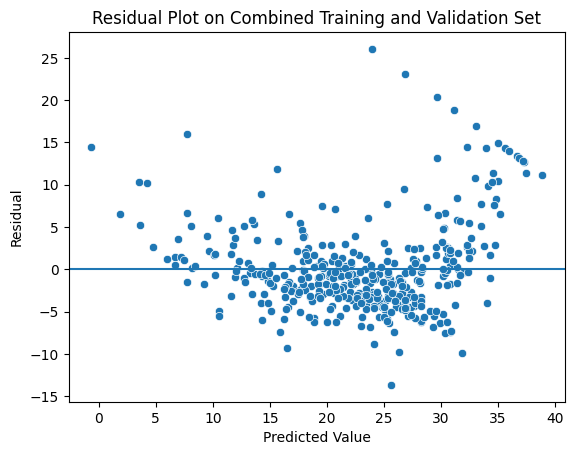

In [ ]:
# Calculate predictions on the training set using the best model (final_lasso)
y_predict_train = final_lasso.predict(X_combined)

# calculate residuals
residual = y_combined.values.flatten() - y_predict_train # Ensure y_combined is a numpy array and flattened for subtraction

# prepare dataframe
# predictor (predicted value) VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.title('Residual Plot on Combined Training and Validation Set')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.show()

<ipython-input-31-de15f7a7b687>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: ylabel='Density'>

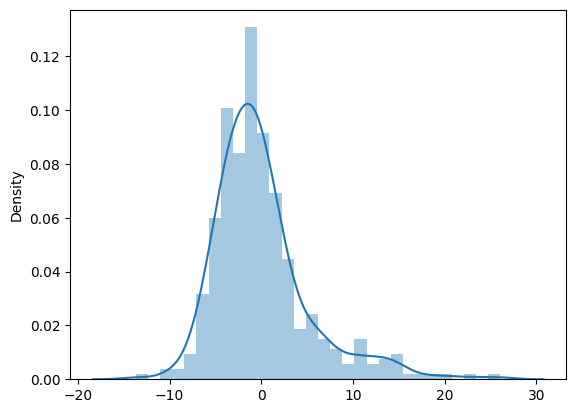

In [ ]:
sns.distplot(residual)

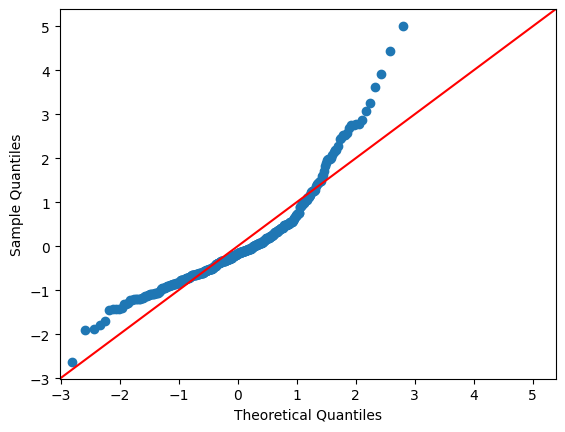

In [ ]:
# QQplot
from sklearn.preprocessing import StandardScaler

std_resid = StandardScaler().fit_transform(residual.reshape(-1,1))
std_resid = np.array([value for nested_array in std_resid for value in nested_array])

import statsmodels.api as sm
sm.qqplot(std_resid, line='45')
plt.show()

In [ ]:
ridge_coef = pd.Series(final_ridge.coef_, index=X_combined.columns)
lasso_coef = pd.Series(final_lasso.coef_, index=X_combined.columns)

print("Ridge Coefficients:\n", ridge_coef)
print("Lasso Coefficients:\n", lasso_coef)

def evaluate(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return mae, mape, rmse

print(f"\nBest Ridge alpha: {best_lambda_ridge}")
print("Ridge - MAE, MAPE, RMSE:", evaluate(final_ridge, feature_boston_test, target_boston_test))

print(f"\nBest Lasso alpha: {best_lambda_lasso}")
print("Lasso - MAE, MAPE, RMSE:", evaluate(final_lasso, feature_boston_test, target_boston_test))

Ridge Coefficients:
 crim      -0.079389
zn         0.024449
indus     -0.042263
chas       2.874742
nox       -8.659523
rm         4.730932
age       -0.014742
dis       -1.330533
tax       -0.000329
ptratio   -0.741570
black      0.011923
lstat     -0.511589
dtype: float64
Lasso Coefficients:
 crim      -0.049602
zn         0.022087
indus     -0.015351
chas       0.000000
nox       -0.000000
rm         1.905552
age        0.014352
dis       -0.615763
tax       -0.002724
ptratio   -0.641701
black      0.010620
lstat     -0.737855
dtype: float64

Best Ridge alpha: 1.0
Ridge - MAE, MAPE, RMSE: (3.282263600369967, 0.1764657835196514, np.float64(5.142105577033607))

Best Lasso alpha: 1.0
Lasso - MAE, MAPE, RMSE: (3.449793944342835, 0.1788546125127309, np.float64(5.14212581584719))


## Interpretasi Hasil
* Secara umum, performa kedua model cukup sebanding, dengan nilai RMSE yang hampir sama (selisih hanya 0.00002).

* Ridge Regression menunjukkan MAE dan MAPE yang lebih rendah sedikit, menandakan prediksi yang lebih stabil dan konsisten dalam meminimalkan kesalahan rata-rata.

* Lasso Regression sedikit lebih buruk dalam MAE dan MAPE, namun memiliki keunggulan dalam seleksi fitur otomatis—beberapa fitur seperti chas dan nox memiliki koefisien nol, artinya model menganggap fitur tersebut tidak signifikan.

## Kesimpulan
Model terbaik secara keseluruhan adalah Lasso Regression dengan alpha = 1.0, karena:

*  RMSE paling rendah (5.1421)

*  MAE masih kompetitif (3.4497)

*  MAPE masih dalam batas wajar (17.88%)